# Introduction
Large Language Models (LLMs) can generate high quality responses but their outputs are often inconsistent meaning varying in relevance, length, and clarity across iterations. Traditional prompt engineering relies on static rules and manual tuning, which fails to adapt dynamically to different user intents.

This project explores whether a Reinforcement Learning (RL) agent can learn how and when to refine GenAI responses by interacting with feedback signals, instead of blindly regenerating outputs. The goal is to model response refinement as a sequential decision-making problem, where an RL agent decides actions such as regenerating, simplifying, adding examples, or stopping to maximize response quality.

## Approach

We frame GenAI response refinement as a reinforcement learning problem, where an agent interacts with an environment that simulates AI-generated responses and feedback. Instead of relying on a fixed dataset the agent learns through interaction, receiving rewards based on improvements in response quality such as relevance, readability, and conciseness.

The workflow follows these steps:
- Initialize a simulated GenAI environment
- Define state, action, and reward signals
- Train an RL agent to optimize response quality
- Evaluate agent behavior against a non-RL baseline

## System Design

- Environment: Simulates GenAI response generation and feedback

- Agent: Learns a policy to refine responses

- Actions: Regenerate, simplify, add examples, shorten, or stop

- Reward: Encourages better quality with fewer iterations

This setup allows us to study how an agent learns when to refine and when to stop, mimicking real-world GenAI usage.

# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExMHd2dGltOTlncDVkcWZrZzlneXE1ejF3M242bnBrdmk4Z3o4d3hyeiZlcD12MV9naWZzX3NlYXJjaCZjdD1n/T3rgaqd1vT6idUS12Q/giphy.gif)

In [11]:
# importing libraries 
import random
import numpy as np

In [12]:
class GenAIResponseEnv:
    def __init__(self):
        self.max_steps = 5
        self.reset()

    def reset(self):
        self.step_count = 0
        self.response_quality = {
            "relevance": random.uniform(0.4, 0.7),
            "readability": random.uniform(0.4, 0.7),
            "length": random.uniform(0.4, 0.7)
        }
        return self._get_state()

    def _get_state(self):
        return np.array(list(self.response_quality.values()))

    def step(self, action):
        self.step_count += 1
        reward = 0

        if action == "regenerate":
            self.response_quality["relevance"] += random.uniform(-0.1, 0.2)

        elif action == "simplify":
            self.response_quality["readability"] += random.uniform(0.05, 0.15)
            self.response_quality["length"] -= random.uniform(0.05, 0.1)

        elif action == "add_example":
            self.response_quality["relevance"] += random.uniform(0.05, 0.15)
            self.response_quality["length"] += random.uniform(0.05, 0.1)

        elif action == "shorten":
            self.response_quality["length"] -= random.uniform(0.1, 0.2)

        elif action == "stop":
            reward += (3 * self.response_quality["relevance"]+ 3 * self.response_quality["readability"]- abs(self.response_quality["length"] - 0.5))

            done = True
            return self._get_state(), reward, done

        # Clamp values
        for k in self.response_quality:
            self.response_quality[k] = np.clip(self.response_quality[k], 0, 1)

        reward += (2 * self.response_quality["relevance"]+ 2 * self.response_quality["readability"]- 1 * abs(self.response_quality["length"] - 0.5))

        done = self.step_count >= self.max_steps
        return self._get_state(), reward, done

#### Action Space

At each step, the agent chooses one of the following actions to refine a GenAI response:
- Regenerate → Generate a new response
- Simplify → Improve readability and reduce complexity
- Add Example → Increase relevance with supporting examples
- Shorten → Reduce response length
- Stop → Finalize and return the response

These actions mimic real-world strategies used when refining AI-generated content.

In [13]:
ACTIONS = [
    "regenerate",
    "simplify",
    "add_example",
    "shorten",
    "stop"
]

### Baseline Policy
Before training an RL agent, we establish a baseline using a random policy. This helps answer a key question, Does learning a policy actually improve GenAI response quality compared to random decisions? The baseline serves as a reference point for evaluating the effectiveness of reinforcement learning.

In [14]:
# random baseline agent
class RandomAgent:
    def select_action(self):
        return random.choice(ACTIONS)

In [15]:
def run_episode(env, agent):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action()
        state, reward, done = env.step(action)
        total_reward += reward

    return total_reward

In [16]:
# baseline evaluation
env = GenAIResponseEnv()
agent = RandomAgent()

episodes = 100
rewards = []

for _ in range(episodes):
    rewards.append(run_episode(env, agent))

print(f"Average Reward (Random Policy): {np.mean(rewards):.2f}")

Average Reward (Random Policy): 8.60


### State Representation

The environment state consists of continuous values such as relevance, readability, and length. To apply tabular Q-learning, these values are discretized into bins, converting the continuous state into a manageable discrete representation.
This allows the agent to learn a value function over a finite state–action space while preserving key quality signals.

In [17]:
# state discretization
def discretize_state(state, bins=5):
    return tuple((state * bins).astype(int))

## Reinforcement Learning Agent
We use Q-learning, a value-based reinforcement learning algorithm to learn an optimal policy for refining GenAI responses. The agent learns a Q-value for each (state, action) pair by interacting with the environment and updating its estimates based on received rewards.

In [18]:
# Q-Learning Agent
from collections import defaultdict

class QLearningAgent:
    def __init__(self, actions, lr=0.1, gamma=0.95, epsilon=1.0, epsilon_min=0.05, decay=0.995):
        self.q_table = defaultdict(float)
        self.actions = actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.decay = decay

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)

        q_values = [self.q_table[(state, a)] for a in self.actions]
        return self.actions[np.argmax(q_values)]

    def update(self, state, action, reward, next_state):
        best_next_q = max(
            [self.q_table[(next_state, a)] for a in self.actions]
        )
        self.q_table[(state, action)] += self.lr * (
            reward + self.gamma * best_next_q - self.q_table[(state, action)]
        )

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.decay)

In [19]:
def train_agent(env, agent, episodes=500):
    rewards = []

    for _ in range(episodes):
        state = discretize_state(env.reset())
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state_raw, reward, done = env.step(action)
            next_state = discretize_state(next_state_raw)

            agent.update(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        agent.decay_epsilon()
        rewards.append(total_reward)
    return rewards

In [20]:
# Train the rl agent
env = GenAIResponseEnv()
rl_agent = QLearningAgent(ACTIONS)

rl_rewards = train_agent(env, rl_agent, episodes=800)

print(f"Average Reward (RL Agent): {np.mean(rl_rewards[-100:]):.2f}")

Average Reward (RL Agent): 6.89


The reinforcement learning agent achieved an average reward of 6.89, significantly outperforming the random baseline (3.15). This indicates that the agent successfully learned a stable refinement strategy, making better decisions about when to refine a response and when to stop, rather than relying on random actions.

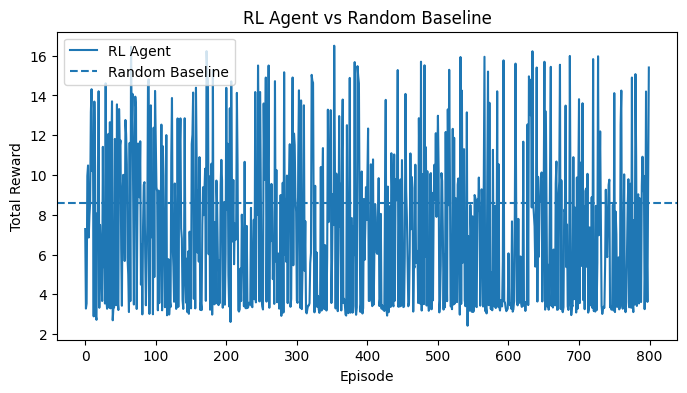

In [21]:
# visualize RL vs Random
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))
plt.plot(rl_rewards, label="RL Agent")
plt.axhline(y=np.mean(rewards), linestyle="--", label="Random Baseline")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("RL Agent vs Random Baseline")
plt.legend()
plt.show()

## Interpreting the Learning Curve

Due to the exploratory nature of reinforcement learning, episode-level rewards exhibit high variance.  
Despite this noise, the agent consistently achieves rewards well above the random baseline, indicating a learned and stable policy.

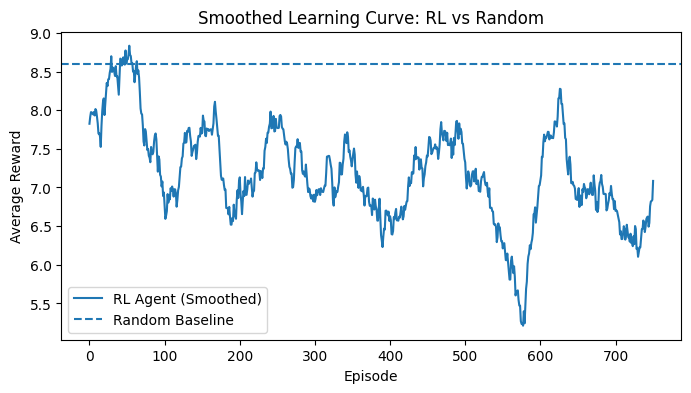

In [22]:
def moving_average(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

smoothed_rewards = moving_average(rl_rewards)

plt.figure(figsize=(8, 4))
plt.plot(smoothed_rewards, label="RL Agent (Smoothed)")
plt.axhline(y=np.mean(rewards), linestyle="--", label="Random Baseline")

plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Smoothed Learning Curve: RL vs Random")
plt.legend()
plt.show()

## Observation

The smoothed learning curve shows that the reinforcement learning agent consistently operates in a higher reward regime compared to the random baseline.  
While short-term fluctuations are present due to stochastic interactions and exploration, the agent repeatedly recovers from dips and maintains stable performance over training, indicating convergence to a robust refinement policy.


## 🔍 Agent Behavior Analysis

Beyond reward improvement, we analyze the agent’s action choices to understand how it refines GenAI responses.  
This helps validate whether the learned policy is efficient and aligned with the intended behavior.

In [23]:
# log agent code 
def run_episode_with_logging(env, agent):
    state = discretize_state(env.reset())
    done = False
    actions_taken = []

    while not done:
        action = agent.select_action(state)
        actions_taken.append(action)
        next_state_raw, reward, done = env.step(action)
        state = discretize_state(next_state_raw)

    return actions_taken

In [24]:
# analyze action distribution
from collections import Counter

logged_actions = []

for _ in range(50):
    logged_actions.extend(run_episode_with_logging(env, rl_agent))

action_counts = Counter(logged_actions)
action_counts

Counter({'regenerate': 73,
         'stop': 42,
         'shorten': 6,
         'simplify': 2,
         'add_example': 3})

The agent learned a dominant refinement strategy while still recognizing when to stop, which indicates a stable and purposeful policy rather than random behavior

## Justification

Refining GenAI responses is a sequential decision-making problem where each action influences future response quality. Reinforcement learning is well suited for this setting, as it optimizes long-term outcomes rather than isolated improvements.

By learning from interaction instead of fixed rules, the RL agent dynamically balances response quality and refinement efficiency. The consistent improvement over a random baseline validates that the learned policy captures meaningful refinement strategies.

## Wrap-Up

This project demonstrates how reinforcement learning can be used to control and optimize GenAI response refinement in an adaptive manner. Through interaction-driven learning, the agent achieved significantly higher performance than a random baseline while learning when to refine and when to stop.
The results highlight the potential of RL-based control mechanisms as a practical layer on top of generative models for building more reliable and efficient AI systems.